In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 30)

## Загрузка данных и анализ общей информации

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

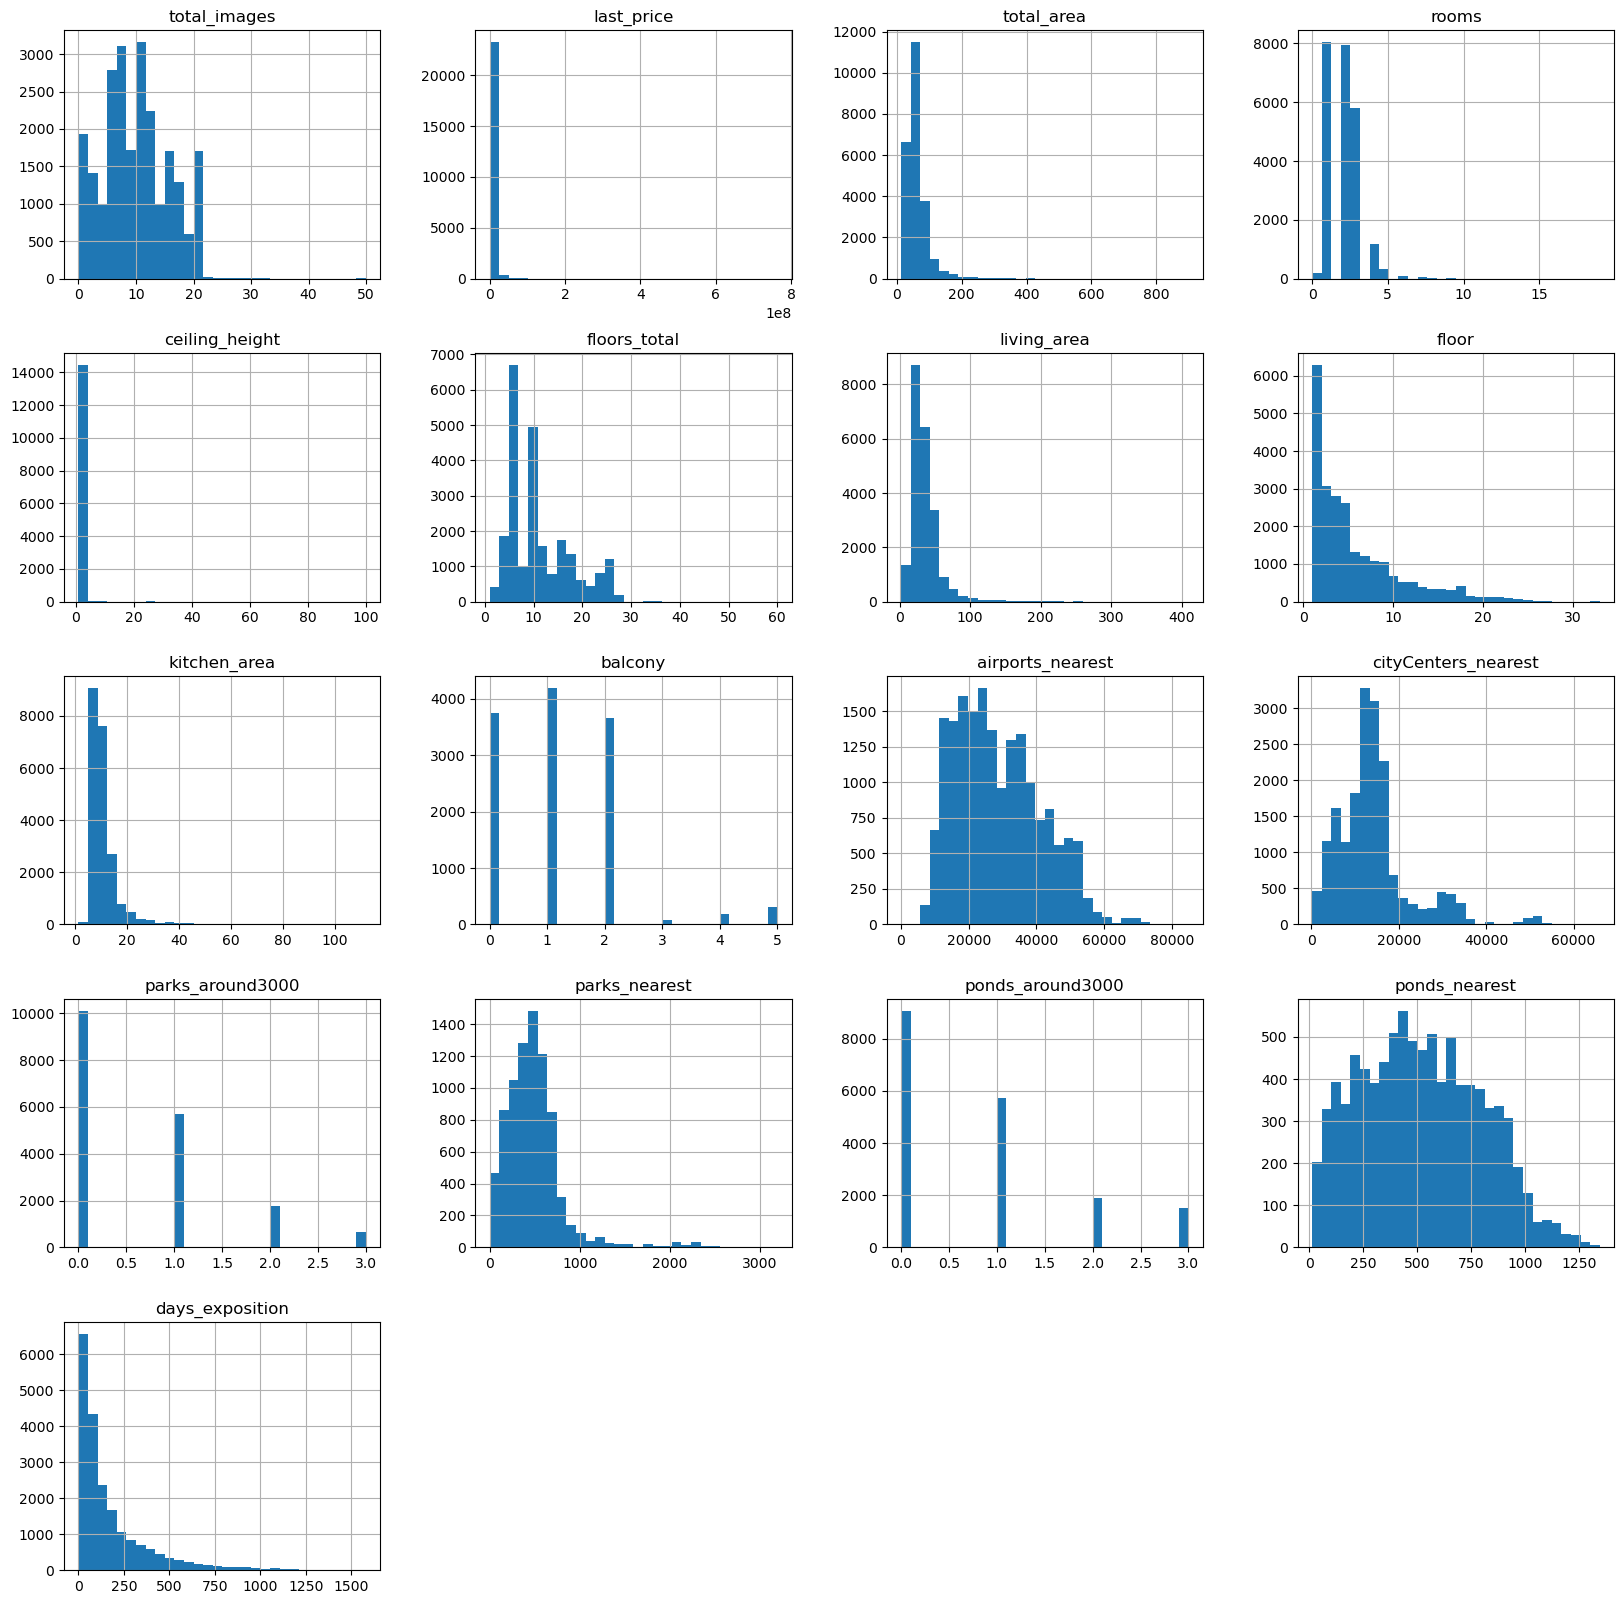

In [5]:
data.hist(figsize=(20, 20), bins=30)
plt.show()

После первоначального анализа данных можно заметить, что для описания недвижимости используется 22 фактора - включая как категориальные, так и числовые переменные. Однако, некоторые из этих факторов содержат пропущенные значения, которые мы будем исправлять в дальнейшем. 

На основе даже первоначальных общих гистограмм (которые содержат пропуски в данных) можно сделать некоторые выводы и о квартирах, и о платформе, на которой были размещены объявления. Так например, в факторе `total_images` виден пик около значения 20, а после наблюдается значительное снижение. Возможно, на платформу нельзя загрузить более 20 фото недвижимости бесплатно. Подробный анализ проведем далее после обработки данных.

## Предобработка данных
### Обработка пропущенных значений

In [6]:
# оценим общее количество пропусков по столбцам
data.isna().sum(axis=0)

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

#### `ceiling_height` - высота потолков (м)

In [7]:
print(f"Процент пропущенных значений: {data['ceiling_height'].isna().mean():0.2f}")

Процент пропущенных значений: 0.39


In [8]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

В данных представлен достаточно большой процент пропусков. Заменим их медианным значением, группируя по количеству комнат. Выберем этот фактор для группировки, основываясь на том, что высота потолка зависит от площади квартиры, но площаль является непреревной величиной и логичнее использовать именно количетсво комнат, которое, в свою очередь, зависит от площади квартиры. 

Напишем функцию для этой задачи, которая вернет 0, 1, 2, 3, 4 или 5 и более комнат. На основе таких категорий правильнее искать медиану, так как мы скорее всего не попадем в ситуацию, когда есть только одна квартира с n-ым количеством комнат для котой не указана высота потолка (как, например, квартира с 19 комнатами).

In [9]:
def categorize_rooms(rooms):
    try:
        if 0 <= rooms < 5:
            return str(rooms)
        elif rooms >= 5:
            return '5 и более'
        else:
            return 'количество комнат отрицательно'
    except TypeError:
        return 'Неверный тип данных'

In [10]:
# добавим новый столбец для количества комнат
data['rooms_cat'] = data['rooms'].apply(lambda x: categorize_rooms(x))
data.pivot_table(index='rooms_cat', values='ceiling_height', aggfunc=['median', 'count'])

,median,count
,ceiling_height,ceiling_height
rooms_cat,,
0,2.75,82
1,2.64,4613
2,2.60,4850
3,2.65,3789
4,2.80,800
5 и более,3.20,370


Догадка подтвердилась. Значения медиан выглядят адекватно и действительно увеличиваются при увеличении количества комнат.

In [11]:
# произведем замену
for t in data['rooms_cat'].unique():
    data.loc[(data['rooms_cat'] == t) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
    data.loc[(data['rooms_cat'] == t), 'ceiling_height'].median()

In [12]:
data['ceiling_height'].isna().mean()

0.0

Убедились, что пропущенные значения действительно были заменены. В дальнейшем проверим это после всех замен.

#### `floors_total` - всего этажей в доме

In [13]:
print(f"Процент пропущенных значений: {data['floors_total'].isna().mean():0.3f}")
print(f"Медианной количество этажей в доме: {data['floors_total'].median()}")

Процент пропущенных значений: 0.004
Медианной количество этажей в доме: 9.0


Пропущенные значения в факторе общего количетсва этажей в доме составляют <1%, поэтому просто заменит их общей медианой по всему столбцу, которая равняется 9 этажам.

In [14]:
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median())

#### `living_area` - жилая площадь в квадратных метрах (м²)

In [15]:
print(f"Процент пропущенных значений: {data['living_area'].isna().mean():0.3f}")

Процент пропущенных значений: 0.080


Относительно большой процент пропусков. Заполним пропуски аналогично фактору `ceiling_height`, но уже на основе общей площади квартиры. И без матрицы корреляции понятно, что чем больше общая площадь, тем больше и жилая.

Напишем функцию для категоризации фактора `total_area`, который представлен в полном виде.

In [16]:
def categorize_total_area(area):
    try:
        if 0 <= area < 40:
            return '<40м'
        elif 40 <= area < 60:
            return '40-60м'
        elif 60 <= area < 80:
            return '60-80м'
        elif 80 <= area < 100:
            return '80-100м'
        elif 100 <= area < 120:
            return '100-120м'
        elif 120 <= area < 140:
            return '120-140м'
        elif area >= 140:
            return '>140м'
        else:
            return 'площадь отрицательная!'
    except TypeError:
        return 'Неверный тип данных'

In [17]:
data['total_area_cat'] = data['total_area'].apply(lambda x: categorize_total_area(x))
data.pivot_table(index='total_area_cat', values='ceiling_height', aggfunc=['median', 'count'])

,median,count
,ceiling_height,ceiling_height
total_area_cat,,
100-120м,2.80,810
120-140м,3.00,393
40-60м,2.60,9074
60-80м,2.65,4978
80-100м,2.70,2012
<40м,2.64,5727
>140м,3.10,705


In [18]:
# произведем замену
for t in data['total_area_cat'].unique():
    data.loc[(data['total_area_cat'] == t) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['total_area_cat'] == t), 'living_area'].median()

#### `is_apartment` - апартаменты (булев тип)

In [19]:
print(f"Процент пропущенных значений: {data['is_apartment'].isna().mean():0.3f}")

Процент пропущенных значений: 0.883


Наблюдаем наибольший процент пропущенных значений, однако восстановить его достаточно легко, если понять, что продавцы квартир, скорее всего, не заполняли данную категорию ввиду того, что у них тип жилье - не апартаменты. Заполним все пропуски нулями.

In [20]:
data['is_apartment'] = data['is_apartment'].fillna(0)

#### `kitchen_area` - площадь кухни в квадратных метрах (м²)

In [21]:
print(f"Процент пропущенных значений: {data['kitchen_area'].isna().mean():0.3f}")

Процент пропущенных значений: 0.096


Аналогично тому, как исправляли фактор жилой площади - исправим и площадь кухни, ведь площадь кухни тоже зависит от общей площади квартиры.

In [22]:
# произведем замену
for t in data['total_area_cat'].unique():
    data.loc[(data['total_area_cat'] == t) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[(data['total_area_cat'] == t), 'kitchen_area'].median()

#### `balcony` - число балконов

In [23]:
print(f"Процент пропущенных значений: {data['balcony'].isna().mean():0.3f}")

Процент пропущенных значений: 0.486


Как и в факторе `is_apartment` продавцы, скорее всего, не указывали ничего в графе `balcony`, если у нет нет ни одного балкона. Заменим все пропуски нулями.

In [24]:
data['balcony'] = data['balcony'].fillna(0)

#### `locality_name` - название населённого пункта

In [25]:
print(f"Процент пропущенных значений: {data['locality_name'].isna().mean():0.3f}")

Процент пропущенных значений: 0.002


Слишком маленький процент пропущенных значений. В данном случае просто удалим эти строки.

In [26]:
data = data.dropna(subset=['locality_name'])

#### Факторы расстояния
`airports_nearest` - расстояние до ближайшего аэропорта в метрах (м)

`cityCenters_nearest` - расстояние до центра города (м)

`parks_around3000` - число парков в радиусе 3 км

`parks_nearest` - расстояние до ближайшего парка (м)

`ponds_around3000` - число водоёмов в радиусе 3 км

`ponds_nearest` - расстояние до ближайшего водоёма (м)

In [27]:
dist_factors = ['airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest',
                'ponds_around3000', 'ponds_nearest']

print('Процент пропущенных значений показателя: ')
for factor in dist_factors:
    print(f" {factor}: {data[factor].isna().mean():0.3f}")

Процент пропущенных значений показателя: 
 airports_nearest: 0.234
 cityCenters_nearest: 0.233
 parks_around3000: 0.233
 parks_nearest: 0.659
 ponds_around3000: 0.233
 ponds_nearest: 0.616


Данные факторы объединяются в одну группу, так как значения в них зависят только от адреса, по которому располагается квартира. Логика заполнения пропущенных значений в них будет одинаковая: заполним медианой на основе названия населенного пункта. Ведь именно зная населенный пункт можно ответить на вопрос: долго ли ехать до аэропорта? или сколько парков в данном районе?

In [28]:
for factor in dist_factors:
    for t in data['locality_name'].unique():
        data.loc[(data['locality_name'] == t) & (data[factor].isna()), factor] = \
        data.loc[(data['locality_name'] == t), factor].median()

In [29]:
print('Процент пропущенных значений показателя: ')
for factor in dist_factors:
    print(f" {factor}: {data[factor].isna().mean():0.3f}")

Процент пропущенных значений показателя: 
 airports_nearest: 0.228
 cityCenters_nearest: 0.228
 parks_around3000: 0.228
 parks_nearest: 0.254
 ponds_around3000: 0.228
 ponds_nearest: 0.232


На данный момент процент пропусков колеблется от 22.8% до 25.4%. **Продолжим эту часть после того, как скорректируем названия населенных пунктов (п. 2.3)**

#### `days_exposition` - сколько дней было размещено объявление (от публикации до снятия)

In [30]:
print(f"Процент пропущенных значений: {data['days_exposition'].isna().mean():0.3f}")

Процент пропущенных значений: 0.134


Пропущенные значения в данном факторе, вероятно, соответствуют объявлениям, которые еще не сняли с сайта (возможно они были только добавлены в день, когда была произведена выгрузка статистики). Можно предположить, что квартиры с определенным метражом в определенных районах продаются за примерно одинаковый срок и заполнить медианой с соответствующей группировкой, однако оставим данный показатель пустым, чтобы можно было анализировать только те квартиры, которые сняли с сайта.

In [31]:
data.isna().sum(axis=0)

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest        5386
cityCenters_nearest     5386
parks_around3000        5386
parks_nearest           5998
ponds_around3000        5386
ponds_nearest           5494
days_exposition         3180
rooms_cat                  0
total_area_cat             0
dtype: int64

В ходе данного этапа обработки данных были скорректированы пропущенные значения в данных недвижимости. Во всех показателях, которые имеют прямое отношение к квартирам, такие как: общая площадь, количество комнат, этаж и т.д. - пропуски были заполнены абсолютно везде. Второстепенные же факторы были специально оставлены с пропусками, так как использую данный датасет нельзя достоверно восстановить эту информацию. К второстепенным факторам относятся: количество водоемов вокруг жилья, расстояние до аэропорта, количество парков рядом с домом и другие.

### Корректировка типов данных

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  object 
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Необходимо скорректировать следующие факторы:
1. first_day_exposition (object -> datetime)
2. is_apartment (object -> bool)

In [33]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['is_apartment'] = data['is_apartment'].astype('bool')

### Удаление дубликатов

In [34]:
data.duplicated().sum()

0

Явных дубликатов не обнаружено. Посмотрим что там с неявными дубликатами. В нашем датасете найти неявные дубликаты можно в колонке `locality_name`.

In [35]:
data['locality_name'].value_counts()

Санкт-Петербург                    15721
посёлок Мурино                       522
посёлок Шушары                       440
Всеволожск                           398
Пушкин                               369
                                   ...  
поселок Каложицы                       1
посёлок Платформа 69-й километр        1
поселок Почап                          1
поселок Гончарово                      1
посёлок Дзержинского                   1
Name: locality_name, Length: 364, dtype: int64

Всего 364 "уникальных" значения, однако даже на первый взгляд видно, что "поселок" пишется по-разному (где-то с буквой "ё", а где-то с буквой "е". Попробуем вообще убрать это слово и оценим как изменилась картина.

In [36]:
def correct_locality_name(localicy_name):
    change_list = ['поселок ', 'городского типа ',
                   'деревня ', 'садовое товарищество ', 'городской ',
                   'станции ', 'село ', 'садоводческое некоммерческое товарищество ',
                   'при железнодорожной ']
    
    localicy_name = localicy_name.replace('ё','е').lower()
    
    for word in change_list:
        localicy_name = localicy_name.replace(word, '')

    localicy_name = localicy_name.title()
    return localicy_name

In [37]:
data['locality_name_correct'] = data['locality_name'].apply(lambda x: correct_locality_name(x))

In [38]:
data['locality_name_correct'].value_counts()

Санкт-Петербург    15721
Мурино               590
Кудрово              472
Шушары               440
Всеволожск           398
                   ...  
Ропша                  1
Алексеевка             1
Белоостров             1
Пельгора               1
Дзержинского           1
Name: locality_name_correct, Length: 306, dtype: int64

Таким образом, получилось скорректировать 58 неявных дублирующих названий.

**Факторы расстояния (продолжение)**
(п 2.1.8)

In [39]:
for factor in dist_factors:
    for t in data['locality_name_correct'].unique():
        data.loc[(data['locality_name_correct'] == t) & (data[factor].isna()), factor] = \
        data.loc[(data['locality_name_correct'] == t), factor].median()

In [40]:
print('Процент пропущенных значений показателя: ')
for factor in dist_factors:
    print(f" {factor}: {data[factor].isna().mean():0.3f}")

Процент пропущенных значений показателя: 
 airports_nearest: 0.204
 cityCenters_nearest: 0.204
 parks_around3000: 0.204
 parks_nearest: 0.254
 ponds_around3000: 0.204
 ponds_nearest: 0.209


Все-таки осталось около 20% квартир, в которых используя только данный датесет нельзя определить факторы расстояний, поэтому сохраним их пустыми.

### Удаление выбросов и корректировка аномальных значений

In [41]:
#TODO

## Feature engineering 

В данном блоке сгенерируем новые признаки на основе имеющихся. Такое мы делали ранее, когда заполняли пропущенные значения. Данные признаки могут быть полезны при исследовательском анализе данных. Приступим!

In [42]:
def floor_type(current_floor, floors_total):
    try:
        if current_floor == floors_total:
            return 'последний'
        elif current_floor == 1:
            return 'первый'
        else:
            return 'другой'
    except:
        return 'не удалось определить этаж'

In [43]:
# цена за один квадратный метр
data['rub_per_metr'] = data['last_price']/data['total_area']

# день недели публикации объявления
data['day_exposition'] = data['first_day_exposition'].dt.day

# месяц публикации объявления
data['month_exposition'] = data['first_day_exposition'].dt.month

# год публикации объявления
data['year_exposition'] = data['first_day_exposition'].dt.year

# тип этажа квартиры
data['floor_type'] = data.apply(lambda row: floor_type(row['floor'],row['floors_total']), axis=1)

# расстояние до центра города в километрах (тип данных оставим float, так как сохранили nan'ы)
data['center_km'] = data['cityCenters_nearest']/1000

Посмотрим какие выводы нам помогут сделать созданные факторы в следующем разделе.

## Исследовательский анализ данных

In [44]:
#TODO